Imports

In [ ]:
#install opencv and matplotlib
pip install opencv-python matplotlib 

In [ ]:
#install tensorflow-gpu
pip install tensorflow-gpu==2.6.0 

In [1]:
import tensorflow as tf
import os #to navigate through file structure

In [2]:
#to limit the GPU usage
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

Filtering Images

In [3]:
import cv2
import imghdr

In [4]:
#set path of folder containing datasets
data_dir = '/content/data'

In [5]:
image_exts = ['jpeg','jpg','bmp','png']

In [7]:
#to remove unwanted images
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path) #open an image using opencv
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print('Image not in ext list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))

Loading Data

In [8]:
tf.data.Dataset??

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
#to build image dataset using keras
data = tf.keras.utils.image_dataset_from_directory('/content/data')

Found 171 files belonging to 2 classes.


In [11]:
#to access generator from pipeline
data_iterator = data.as_numpy_iterator()

In [12]:
#fetch a batch
batch = data_iterator.next()

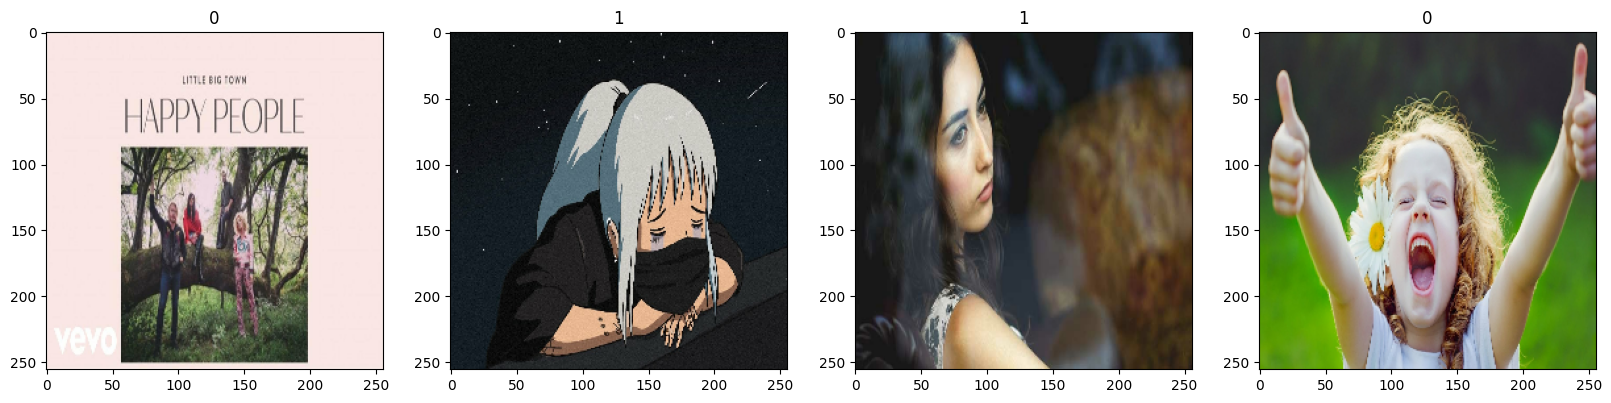

In [13]:
#visualize
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

Preprocess Data

Scale Data

In [14]:
#get data when we load batch and divide it by 255 for scaling
data = data.map(lambda x, y: (x/255, y))

In [ ]:
data.as_numpy_iterator().next()

Split Data

In [16]:
train_size = int(len(data)*.5)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [28]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(test_size+val_size).take(test_size)

Model

Build

In [34]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

In [35]:
#initialize a model
model = Sequential()

In [36]:
from keras.preprocessing.image import ImageDataGenerator
#add convolutional layer and max pooling layer no. of filter, size of filters, stride
model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D()) 
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Flatten()) 

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [37]:
#using adam optimizer
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Training

In [42]:
#set path of folder where you want to store the logs
logdir = "/logs"

In [43]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
#fit used to train data
hist = model.fit(train, epochs=28, validation_data=val, callbacks=[tensorboard_callback])

Plotting Perf

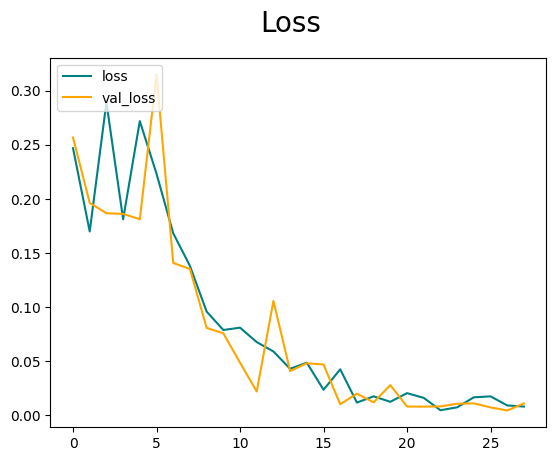

In [45]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluate

In [46]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [47]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [48]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 0s 114ms/step


In [49]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


Testing

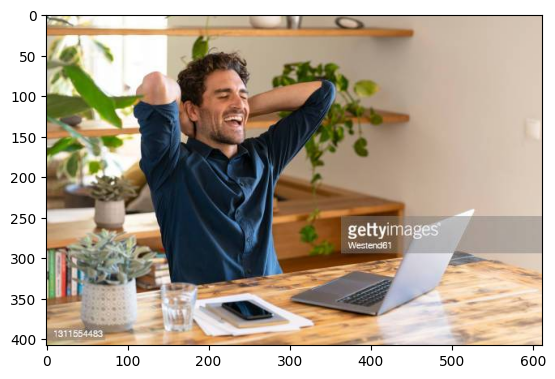

In [65]:
img = cv2.imread('/happytest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

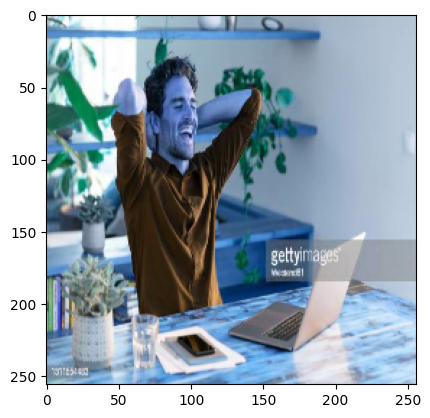

In [66]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [67]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 21ms/step


In [68]:
yhat

array([[0.10268503]], dtype=float32)

In [69]:
if yhat > 0.5:
  print(f'Result: Sad')
else:
  print(f'Result: Happy')

Result: Happy


Saving model

In [70]:
from tensorflow.keras.models import load_model

In [71]:
model.save(os.path.join('models','happySadClassifierModel.h5'))

In [72]:
new_model = load_model(os.path.join('models', 'happySadClassifierModel.h5'))

In [75]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 19ms/step


In [76]:
if yhatnew > 0.5:
  print(f'Result: Sad')
else:
  print(f'Result: Happy')

Result: Happy
